In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels as sm
%matplotlib inline

In [2]:
wildlife = pd.read_csv('../clean_data/wildlife_clean.csv', parse_dates=['CALL_SAVED_TIME'])

In [3]:
wildlife.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152743 entries, 0 to 152742
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Unnamed: 0       152743 non-null  int64         
 1   CALL_REGION      152743 non-null  object        
 2   CALL_SAVED_TIME  152672 non-null  datetime64[ns]
 3   CA_ANIMAL_TYPE   152743 non-null  object        
 4   reason_for_call  152743 non-null  object        
 5   type_of_calls    152743 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 7.0+ MB


In [4]:
wildlife.head()

,Unnamed: 0,CALL_REGION,CALL_SAVED_TIME,CA_ANIMAL_TYPE,reason_for_call,type_of_calls
0,0,Central,2020-01-01,Deer,rescue,report_calls
1,1,Central,2020-01-01,Deer,rescue,report_calls
2,2,Central,2020-01-01,Deer,rescue,report_calls
3,3,Aberdeen,2020-01-01,Wild Bird,injury,report_calls
4,4,Central,2020-01-01,Gull,injury,report_calls


# Prediction of injuries calls

## Choosing the best model through train/test split up

In [5]:
wildlife_injuries = wildlife[wildlife['reason_for_call']=='injury'].copy()
df_time = wildlife_injuries.groupby(['CALL_SAVED_TIME']).count()
df_time.head()

,Unnamed: 0,CALL_REGION,CA_ANIMAL_TYPE,reason_for_call,type_of_calls
CALL_SAVED_TIME,,,,,
2018-01-01,34,34,34,34,34
2018-01-02,33,33,33,33,33
2018-01-03,44,44,44,44,44
2018-01-04,29,29,29,29,29
2018-01-05,44,44,44,44,44


In [6]:
df_time.shape

(851, 5)

In [7]:
# to find 20% of all rows
x = 851 *0.2
851 - x

680.8

In [8]:
train=df_time[0:681] 
test=df_time[681:]

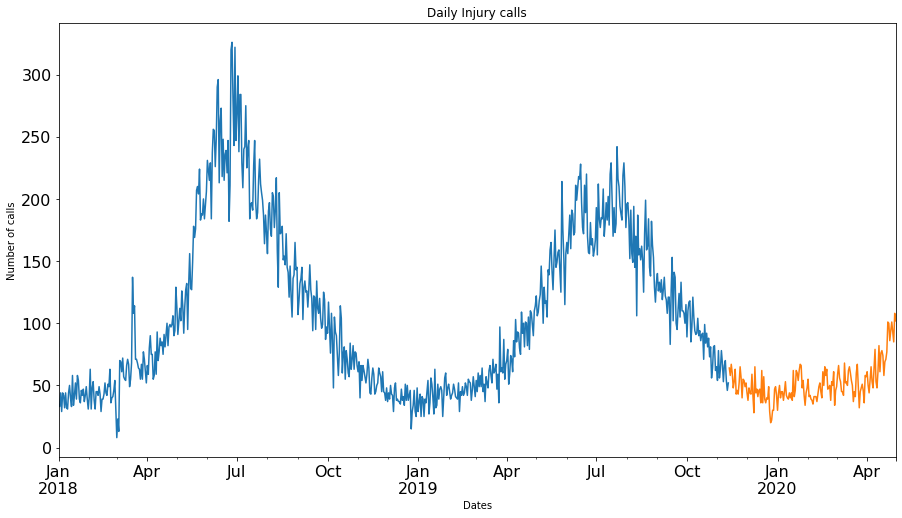

In [9]:
train.reason_for_call.plot(figsize=(15,8), title= 'Daily Injury calls', fontsize=16)
test.reason_for_call.plot(figsize=(15,8), title= 'Daily Injury calls', fontsize=16)
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()
# injury data split into train and test 

## Naive

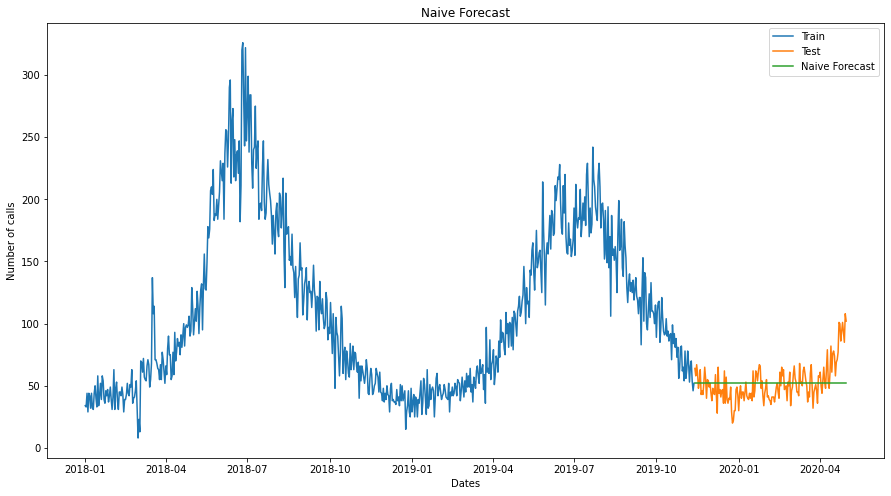

In [10]:
dd= np.asarray(train.reason_for_call)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(15,8))
plt.plot(train.index, train['reason_for_call'], label='Train')
plt.plot(test.index,test['reason_for_call'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms_naive = sqrt(mean_squared_error(test.reason_for_call, y_hat.naive))
print(rms_naive)

15.38907175276549


## Moving average

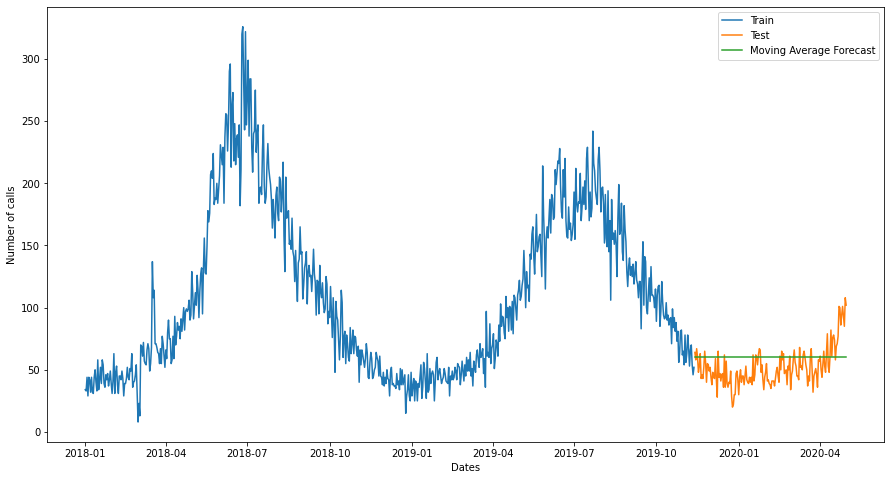

In [12]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['reason_for_call'].rolling(10).mean().iloc[-1]
plt.figure(figsize=(15,8))
plt.plot(train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [13]:
rms_avg = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg.moving_avg_forecast))
print(rms_avg)

17.473408368146153


## SARIMA

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


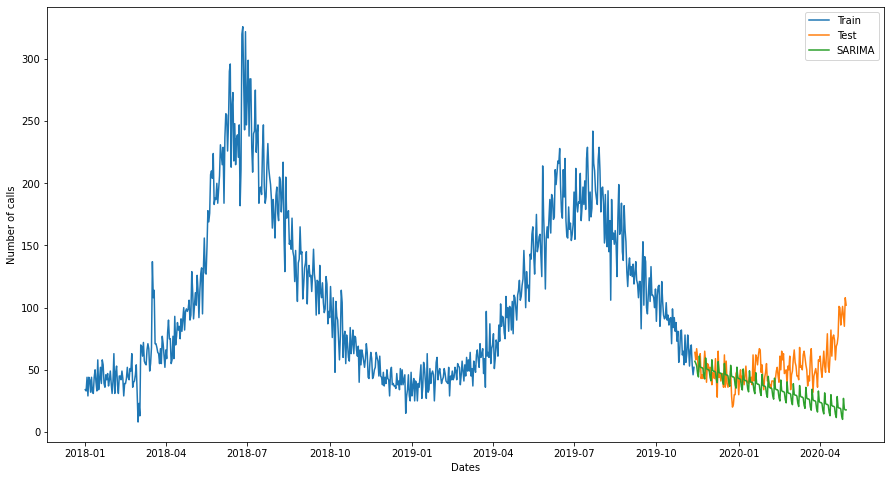

In [14]:
import statsmodels.api as sm

y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.reason_for_call, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2019-11-13", end="2020-04-30", dynamic=True)
plt.figure(figsize=(15,8))
plt.plot( train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [15]:
rms_sarima = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg.SARIMA))
print(rms_sarima)

28.66247948975563


## Holt Winter

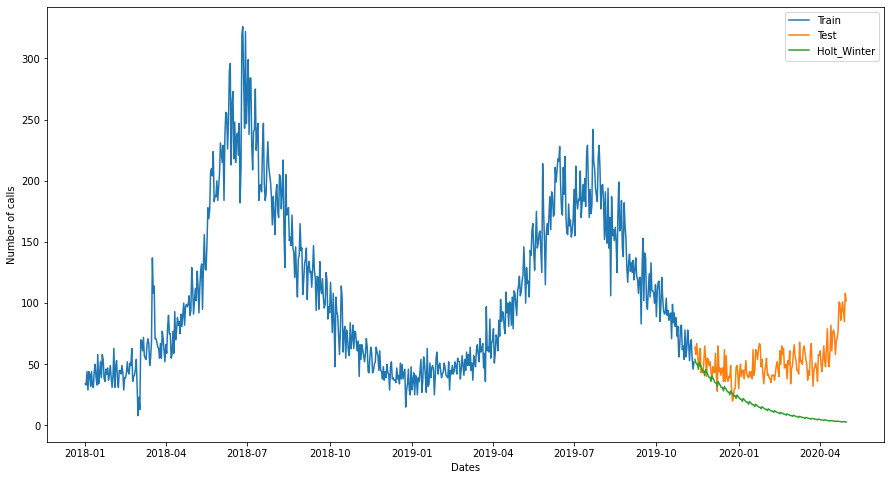

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['reason_for_call']) ,seasonal_periods=7 ,trend='mul', seasonal='mul',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(15,8))
plt.plot( train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [17]:
rms_holt = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg.Holt_Winter))
print(rms_holt)

42.23063197966881


## SES

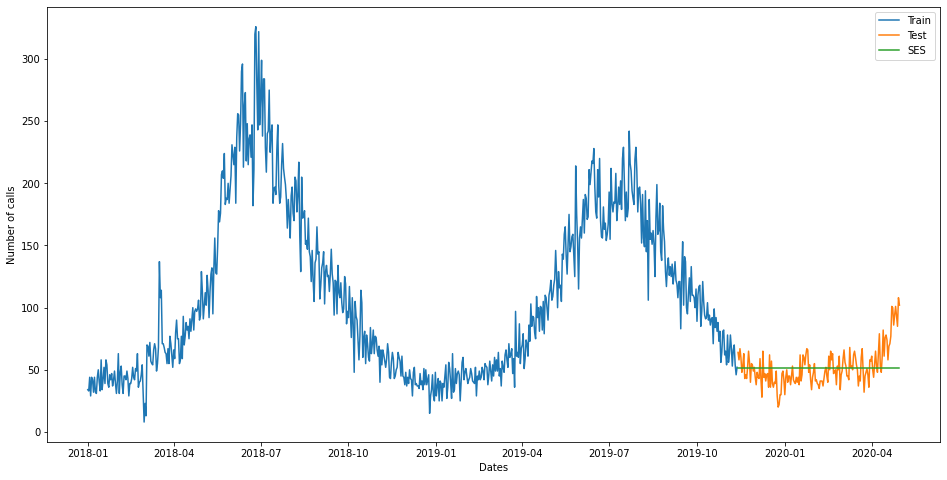

In [18]:
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['reason_for_call'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [19]:
rms_ses = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg.SES))
print(rms_ses)

15.396777908048401


## Seasonal naive

In [20]:
test_sn = test.reset_index()
train_sn = train.reset_index()

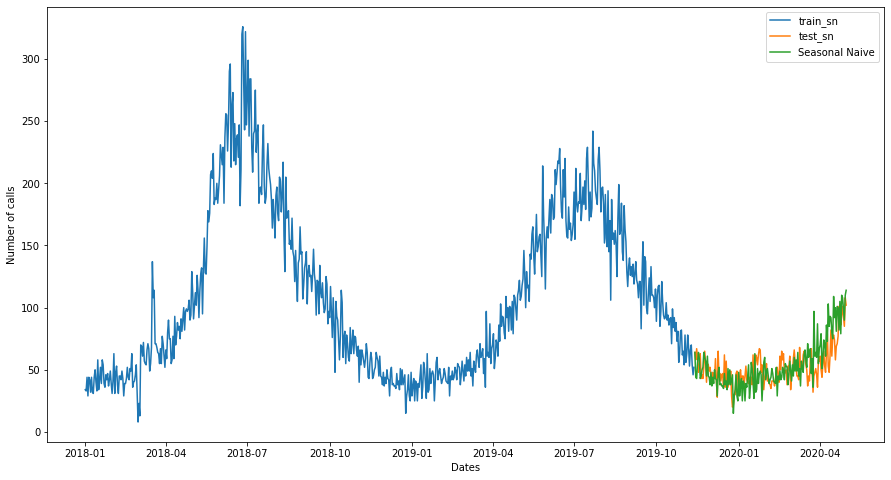

In [21]:
dates = (test_sn['CALL_SAVED_TIME'] - np.timedelta64(1, 'Y')).values.astype('datetime64[D]')
seasonal_naive = train_sn[train_sn['CALL_SAVED_TIME'].isin(dates)]['reason_for_call'] # seasonal naive prediction
y_hat_sn = test_sn.copy().drop('reason_for_call', axis=1)
y_hat_sn['seasonal_naive'] = pd.DataFrame(seasonal_naive).set_index(test_sn.index)
plt.figure(figsize=(15,8))
plt.plot(train_sn['CALL_SAVED_TIME'], train_sn['reason_for_call'], label='train_sn')
plt.plot(test_sn['CALL_SAVED_TIME'], test_sn['reason_for_call'], label='test_sn')
plt.plot(y_hat_sn['CALL_SAVED_TIME'], y_hat_sn['seasonal_naive'], label='Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [22]:
rms_snaive = sqrt(mean_squared_error(test_sn.reason_for_call, y_hat_sn.seasonal_naive))
print(rms_snaive)

15.193264761651692


# Summary of models

**Summary of models**

| Model| RMSE |
| :---| :--- |  
| Naive | 15.39 |
| Moving avg | 17.47 |
| SARIMA | 28.66 |
| Holt Winter | 42.24 |
| SES | 15.39 |
| SNaive | 15.19 |

Out of 6 models, the lowest RMSE has SNaive model and will be used for further forecasting.

# Forecasting modelling

## Injuries predictions

In [23]:
rng = pd.date_range('2020-05-01', periods=610, freq='D')
df_pred = pd.DataFrame({ 'CALL_SAVED_TIME': rng, 'reason_for_call' : np.random.randn(len(rng))}) 
df_pred.head()
# creating dummy data with dates that is interest in the future

,CALL_SAVED_TIME,reason_for_call
0,2020-05-01,0.276934
1,2020-05-02,0.356067
2,2020-05-03,0.849271
3,2020-05-04,-1.557338
4,2020-05-05,0.250416


In [24]:
df_time_sn = df_time.reset_index()

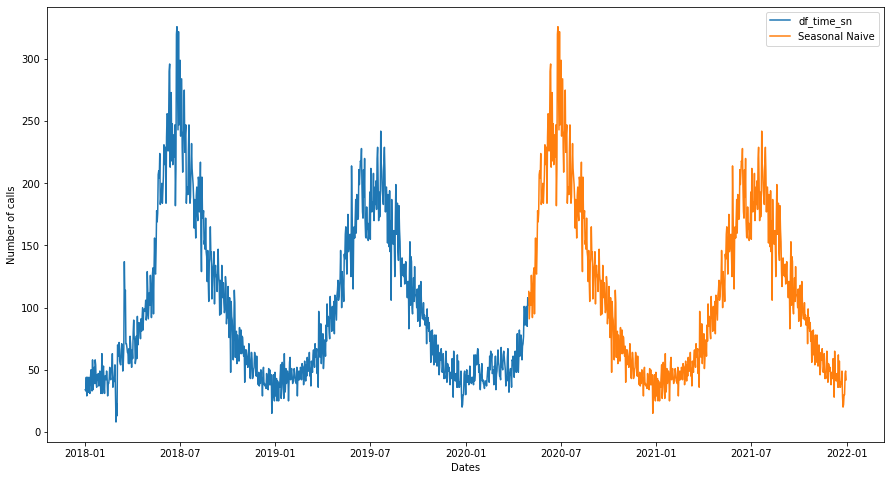

In [25]:
dates = (df_pred['CALL_SAVED_TIME'] - np.timedelta64(2, 'Y')).values.astype('datetime64[D]')
seasonal_naive = df_time_sn[df_time_sn['CALL_SAVED_TIME'].isin(dates)]['reason_for_call'] # seasonal naive prediction
y_hat_sn = df_pred.copy().drop('reason_for_call', axis=1)
y_hat_sn['seasonal_naive'] = pd.DataFrame(seasonal_naive).set_index(df_pred.index)
plt.figure(figsize=(15,8))
plt.plot(df_time_sn['CALL_SAVED_TIME'], df_time_sn['reason_for_call'], label='df_time_sn')
plt.plot(y_hat_sn['CALL_SAVED_TIME'], y_hat_sn['seasonal_naive'], label='Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [26]:
y_hat_sn.head()
#predicted numbers in seasonal_naive

,CALL_SAVED_TIME,seasonal_naive
0,2020-05-01,113
1,2020-05-02,91
2,2020-05-03,101
3,2020-05-04,112
4,2020-05-05,102


## All calls predictions

In [27]:
calls = wildlife.groupby('CALL_SAVED_TIME').count()
calls.head()

,Unnamed: 0,CALL_REGION,CA_ANIMAL_TYPE,reason_for_call,type_of_calls
CALL_SAVED_TIME,,,,,
2018-01-01,59,59,59,59,59
2018-01-02,58,58,58,58,58
2018-01-03,78,78,78,78,78
2018-01-04,67,67,67,67,67
2018-01-05,84,84,84,84,84


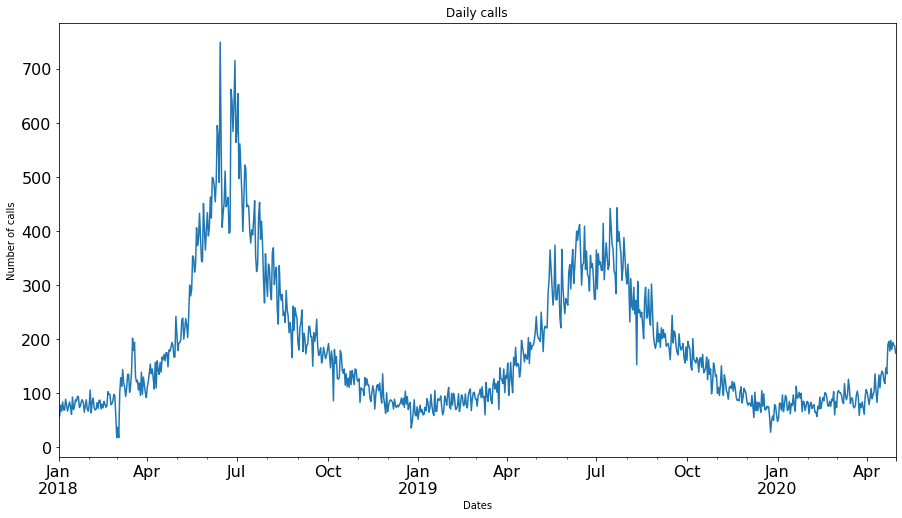

In [28]:
calls.type_of_calls.plot(figsize=(15,8), title= 'Daily calls', fontsize=16)
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [29]:
calls = calls.reset_index()

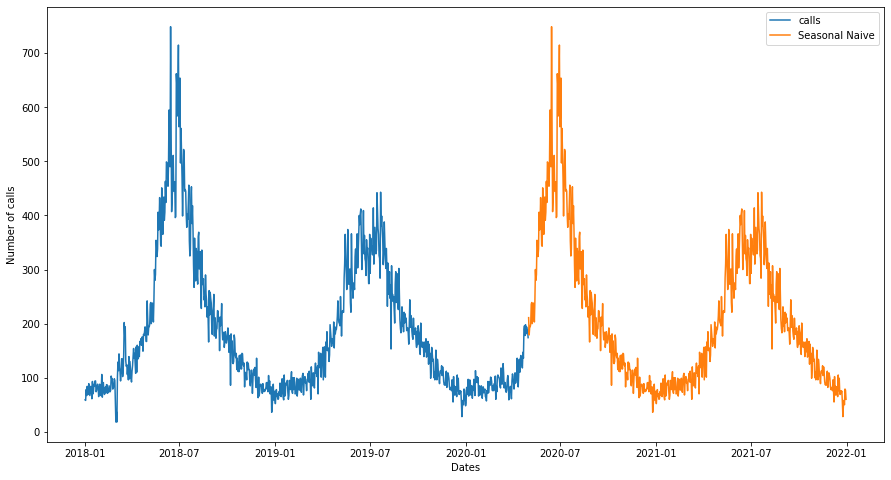

In [30]:
dates = (df_pred['CALL_SAVED_TIME'] - np.timedelta64(2, 'Y')).values.astype('datetime64[D]')
seasonal_naive = calls[calls['CALL_SAVED_TIME'].isin(dates)]['reason_for_call'] # seasonal naive prediction
y_hat_sn = df_pred.copy().drop('reason_for_call', axis=1)
y_hat_sn['seasonal_naive'] = pd.DataFrame(seasonal_naive).set_index(df_pred.index)
plt.figure(figsize=(15,8))
plt.plot(calls['CALL_SAVED_TIME'], calls['reason_for_call'], label='calls')
plt.plot(y_hat_sn['CALL_SAVED_TIME'], y_hat_sn['seasonal_naive'], label='Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [31]:
y_hat_sn.head()
# predicted numbers in seasonal_naive

,CALL_SAVED_TIME,seasonal_naive
0,2020-05-01,211
1,2020-05-02,179
2,2020-05-03,193
3,2020-05-04,194
4,2020-05-05,199


In summary, these two models look similar to each other, it is only the calls model has more number of calls as it includes all the calls, while injuries include only injuries calls. Also, SNaive just repeats what happened in the past at the same season. So it looks like the predictions is overfitted because there is no trend noticed (which is the decreasing one). This is why Prophet model was decided to perform as it is more complex than Snaive and will allow to see the errors with which it predicts.

# Prophet

In [32]:
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Importing plotly failed. Interactive plots will not work.


Prophet 0.6


In [33]:
df_time = df_time.reset_index()

In [34]:
df_prophet = df_time.loc[:,['CALL_SAVED_TIME','reason_for_call']].copy()
df_prophet = pd.DataFrame(df_prophet).copy()
df_prophet.columns = ['ds', 'y']
#prophet requires ds and y columns

In [35]:
from fbprophet import Prophet
model = Prophet()
# fit the model
model.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds        yhat  yhat_lower  yhat_upper
0 2020-01-01   38.958002   15.806504   59.821595
1 2020-02-01   41.120772   19.419113   61.061901
2 2020-03-01   43.781385   20.812948   65.769386
3 2020-04-01   59.308835   36.007251   82.974859
4 2020-05-01  100.836929   79.539071  123.057484


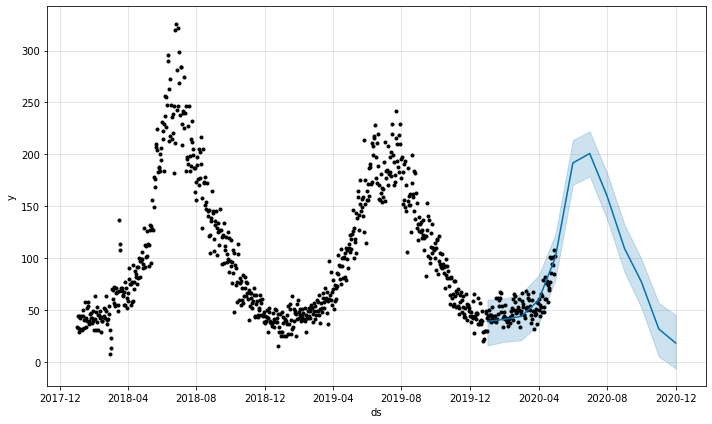

In [36]:
from datetime import datetime
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '2020-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [37]:
#create 20 months of future data
future_data = model.make_future_dataframe(periods=20, freq = 'm')

#forecast the data for future data
forecast_data = model.predict(future_data)

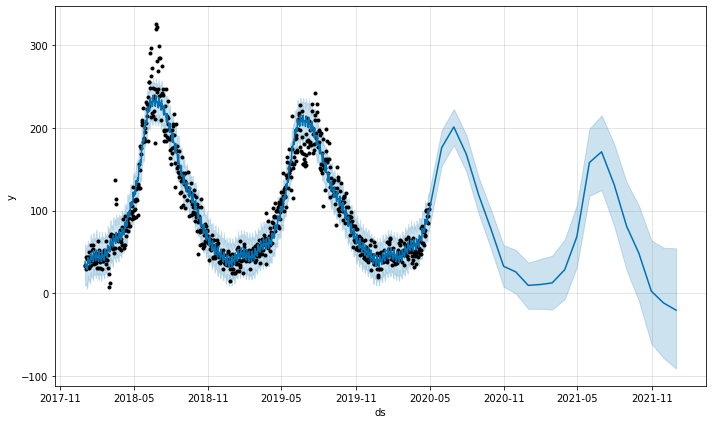

In [38]:
model.plot(forecast_data);

In [39]:
forecast = model.predict(future_data)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01,38.102817,16.077860,60.092443
1,2018-01-02,31.315849,9.298932,52.445888
2,2018-01-03,31.987941,9.134924,54.724077
3,2018-01-04,33.735797,11.630083,56.686490
4,2018-01-05,34.803810,11.461291,55.480499
...,...,...,...,...
866,2021-08-31,81.054111,24.142972,134.812190
867,2021-09-30,48.773334,-13.816129,103.132966
868,2021-10-31,2.739997,-63.868246,64.894217
869,2021-11-30,-11.459905,-77.496985,56.611267


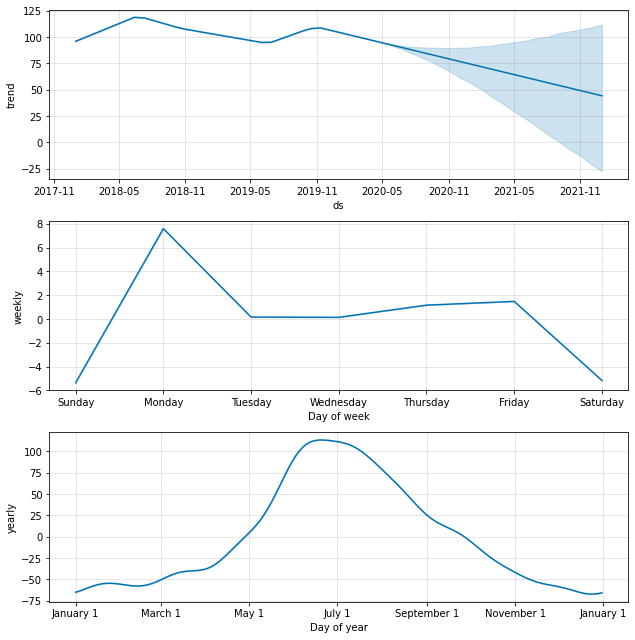

In [41]:
model.plot_components(forecast);

Prophet shows trend in general, weekly and yearly. It also shows prediction for all 2021 year. Although, there is only 2 seasons in data so it might be too risky to say that the trend is decreasing. Also some values are negative and it cannot be true. 

# Cross validation of Prophet

In [50]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='540 days', period='90 days', horizon = '180 days')
df_cv.head()
# y is true value and ythat is predicted

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-08-04 00:00:00 and 2019-11-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-08-05,170.669078,146.698201,194.840744,191,2019-08-04
1,2019-08-06,160.480778,136.081773,183.391472,156,2019-08-04
2,2019-08-07,156.958703,133.169577,180.910988,149,2019-08-04
3,2019-08-08,155.363694,130.211264,178.930591,194,2019-08-04
4,2019-08-09,154.381936,130.681882,176.982403,145,2019-08-04


In [51]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,719.141753,26.816818,21.528774,0.222852,0.186919,0.638889
1,19 days,862.350341,29.365802,23.355728,0.241115,0.196627,0.583333
2,20 days,928.316522,30.468287,24.730395,0.259550,0.200267,0.527778
3,21 days,970.390142,31.151086,25.793951,0.270928,0.231654,0.500000
4,22 days,1062.599307,32.597535,26.535188,0.274299,0.246160,0.500000


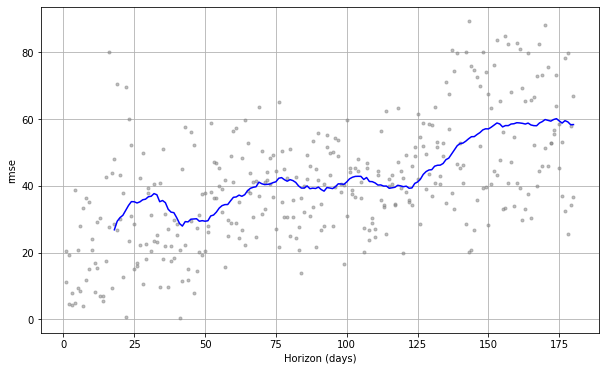

In [44]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')
# rmse increasing as hoizon increases (how far into the future the prediction was)

# Volume of calls

In [45]:
prophet_calls = calls.loc[:,['CALL_SAVED_TIME','type_of_calls']].copy()
prophet_calls = pd.DataFrame(prophet_calls).copy()
prophet_calls.columns = ['ds', 'y']

In [46]:
model_calls = Prophet()
model_calls.fit(prophet_calls)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


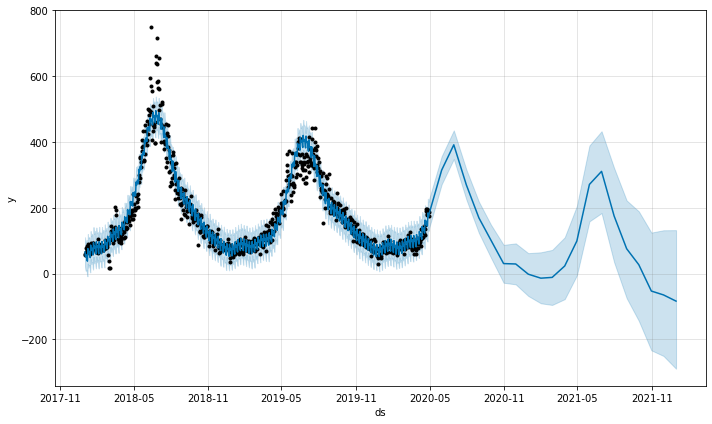

In [52]:
#create 20 months of future data
future_data = model_calls.make_future_dataframe(periods=20, freq = 'm')

#forecast the data for future data
forecast_data = model_calls.predict(future_data)

model_calls.plot(forecast_data);

In [53]:
forecast = model_calls.predict(future_data)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01,65.836116,20.690934,107.442168
1,2018-01-02,51.924740,5.116381,95.239289
2,2018-01-03,51.347234,7.898049,93.960060
3,2018-01-04,57.301144,14.354023,99.463354
4,2018-01-05,56.123055,10.476303,98.558501
...,...,...,...,...
866,2021-08-31,75.703589,-91.855123,229.896314
867,2021-09-30,27.126219,-161.145465,194.396190
868,2021-10-31,-52.876723,-256.047171,124.709900
869,2021-11-30,-64.645161,-284.271739,129.326390


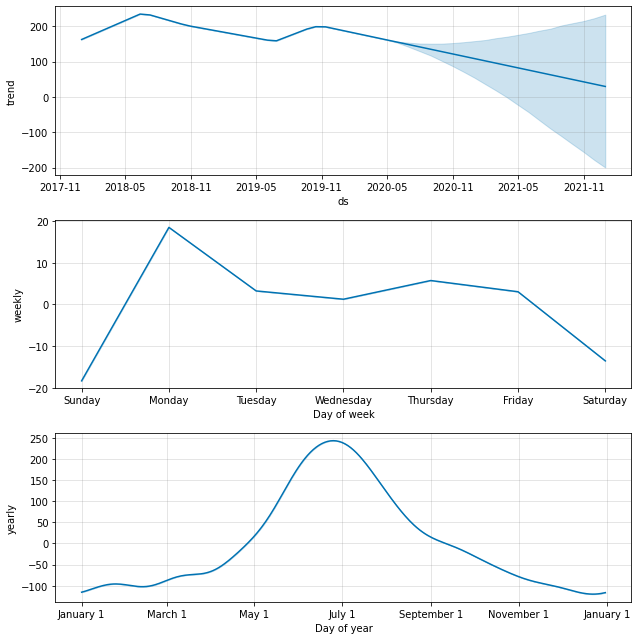

In [54]:
model_calls.plot_components(forecast);

Injury calls and all calls have very similar models. It both decreases in general with time.